In [1]:
import os
import math
import copy
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import tensorflow as tf
import tensorflow_hub as hub

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

warnings.filterwarnings(action='once')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(64)

save_path = 'Training_results/Harvey_Beryl_Imelda_5foldcv_BCE_Multihead_Deep_Sigmoid/'
os.makedirs(save_path, exist_ok=True)

def haversine(lat1, lon1, lat2, lon2):
    R = 3959  
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def get_box_area(lat1, lon1, lat2, lon2):
    side1 = haversine(lat1, lon1, lat1, lon2)
    side2 = haversine(lat1, lon1, lat2, lon1)
    return side1 * side2

# Adjust the path to point to the directory containing 'saved_model.pb'
model_path = "nnlm_model/nnlm-tensorflow2-en-dim128-v1/"

hub_layer = hub.KerasLayer(model_path, input_shape=[], dtype="string", trainable=True)

print("Model loaded successfully!")

def get_target_list(target_list=[]):
    if not target_list:
        target_list = [
            'homeOwnersInsurance', 'floodInsurance', 'destroyed', 'floodDamage', 'roofDamage', 
            'tsaEligible', 'tsaCheckedIn', 'rentalAssistanceEligible', 'repairAssistanceEligible', 
            'replacementAssistanceEligible', 'personalPropertyEligible'
        ]
    return target_list


def grouped_tweets_to_dict(tweet_grouped):
    return {int(name): group['text'] for name, group in tweet_grouped}


def grouped_targets_to_dict(target_grouped, target_list):
    return {int(name): group[target_list] for name, group in target_grouped}


def get_intersection_keys(tweet_dict, target_dict):
    return list(set(target_dict.keys()) & set(tweet_dict.keys()))


def pair_data_together(intersection, tweet_dict, target_dict):
    return {name: [target_dict[name].sum().apply(lambda x: 1 if x > 0 else 0), tweet_dict[name]] for name in intersection}


def pair_data_together_target_non_binary(intersection, tweet_dict, target_dict):
    return {name: [target_dict[name].sum(), tweet_dict[name]] for name in intersection}


def get_class_weights(paired_dict):
    pos_counts = np.zeros(len(paired_dict[list(paired_dict.keys())[0]][0]))
    for i in paired_dict.keys():
        pos_counts += paired_dict[i][0]
    neg_counts = len(paired_dict.keys()) - pos_counts
    return neg_counts / pos_counts


def load_embedding_model(emb_model_str):
    model_path = hub.resolve(emb_model_str)
    return hub.KerasLayer(model_path, input_shape=[], dtype=tf.string, trainable=True)


def paired_data_to_Xy(paired_data, hub_layer):
    X, y = [], []
    for k, v in paired_data.items():
        y.append(np.array(v[0]))
        text = '\n'.join(v[1].to_list())
        vector = hub_layer([text]).numpy()
        X.append(vector)
    return np.array(X), np.array(y)

def tweet_data_to_X_dict(tweet_data, hub_layer):

    X_dict = {}
    for k, v in tweet_data.items():
        
        X = []
        text = '\n'.join(v.to_list())
        vector = hub_layer([text]).numpy()
        X.append(vector)
        X_dict[k] = np.array(X)
        
    return X_dict

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx][0], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

class MultiHeadSimplerNet(nn.Module):
    def __init__(self, in_out_degrees, num_heads):
        super(MultiHeadSimplerNet, self).__init__()
        self.backbone = nn.Sequential(
            *[nn.Linear(in_out_degrees[i], in_out_degrees[i+1]) for i in range(len(in_out_degrees) - 1)],
            nn.ReLU()
        )
        self.heads = nn.ModuleList([nn.Linear(in_out_degrees[-1], 1) for _ in range(num_heads)])

    def forward(self, x):
        x = self.backbone(x)
        return [torch.sigmoid(head(x)) for head in self.heads]

class MultiHeadComplexNet(nn.Module):
    def __init__(self, in_out_degrees, num_heads, head_hidden_layers=2, head_hidden_dim=64):
        super(MultiHeadComplexNet, self).__init__()
        self.backbone = nn.Sequential(
            *[nn.Linear(in_out_degrees[i], in_out_degrees[i+1]) for i in range(len(in_out_degrees) - 1)],
            nn.ReLU()
        )

        # More complex heads with multiple layers
        self.heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(in_out_degrees[-1], head_hidden_dim),
                nn.ReLU(),
                *[nn.Sequential(nn.Linear(head_hidden_dim, head_hidden_dim), nn.ReLU()) for _ in range(head_hidden_layers)],
                nn.Linear(head_hidden_dim, 1)
            ) 
            for _ in range(num_heads)
        ])

    def forward(self, x):
        x = self.backbone(x)
        return [torch.sigmoid(head(x)) for head in self.heads]

def kfoldcv(X, y, train_batch_size=32, val_batch_size=32, weight_by_class=True, test_split=0.2, num_epochs = 3000):

    saved_models = []
    
    print(X.shape, y.shape)
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_results = []
    target_f1_scores = {target: [] for target in target_list}
    target_accuracies = {target: [] for target in target_list}
    
    for fold, (train_idx, test_idx) in enumerate(kfold.split(X, y)):
        print(f"Training fold {fold + 1}...")
        
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        train_dataset = CustomDataset(X_train, y_train)
        test_dataset = CustomDataset(X_test, y_test)
        train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
        val_loader = DataLoader(test_dataset, batch_size=val_batch_size, shuffle=False)
        
        model = MultiHeadComplexNet([128, 256, 64, 32], num_heads=11).to(device)
        optimizer = torch.optim.Adam(model.parameters())
        criterion = [nn.BCELoss() for _ in range(11)]
        
        best_model, history, history_per_target = loop(model, optimizer, criterion, n_epochs=num_epochs, 
                                                        train_dataloader=train_loader, val_dataloader=val_loader,
                                                        model_name=f"model_fold_{fold + 1}.pth", device=device)
        
        saved_models.append(best_model)
        fold_results.append({
            'fold': fold + 1,
            'f1_score': np.mean(history['f1']),
            'accuracy': np.mean(history['acc']),
            'history': history,
            'history_per_target': history_per_target
        })

        for i, target in enumerate(target_list):
            target_f1 = np.mean(history_per_target[i]['f1'])
            target_acc = np.mean(history_per_target[i]['acc'])
            target_f1_scores[target].append(target_f1)
            target_accuracies[target].append(target_acc)

    combined_results = {'fold': range(1, 6)}
    for target in target_list:
        combined_results[f'{target}_f1'] = target_f1_scores[target]
        combined_results[f'{target}_accuracy'] = target_accuracies[target]
    
    combined_df = pd.DataFrame(combined_results)
    print(combined_df.set_index('fold'))

    # Compute average F1-score and accuracy for each target
    avg_target_f1_scores = {target: np.mean(scores) for target, scores in target_f1_scores.items()}
    avg_target_accuracies = {target: np.mean(scores) for target, scores in target_accuracies.items()}
    
    # Create a dictionary for the average row
    avg_row = {'fold': 'Average'}
    for target in target_list:
        avg_row[f'{target}_f1'] = avg_target_f1_scores[target]
        avg_row[f'{target}_accuracy'] = avg_target_accuracies[target]
    
    # Append the average row using pd.concat()
    combined_df = pd.concat([combined_df, pd.DataFrame([avg_row])], ignore_index=True)
    
    # Print the final DataFrame with the added average row
    print(combined_df.set_index('fold'))

    # Define the file path
    excel_file_path = os.path.join(save_path,"kfold_results.xlsx")
    
    # Save the DataFrame as an Excel file
    combined_df.to_excel(excel_file_path, index=False)
    
    print(f"Results saved to {excel_file_path}")

    avg_f1 = np.mean([result['f1_score'] for result in fold_results])
    avg_acc = np.mean([result['accuracy'] for result in fold_results])
    print(f"\nAverage F1 Score: {avg_f1:.4f}, Average Accuracy: {avg_acc:.4f}")
    
    return fold_results, saved_models

def loop(model, optimizer, criterion, n_epochs, train_dataloader, val_dataloader, 
         model_name='model_state_bi.pth', device='mps', previous_loss_scale=1.05, epoch_percentage=0.1):
    
    history = {'train': [], 'test': [], 'f1': [], 'acc': []}
    history_per_target = {i: {'f1': [], 'acc': []} for i in range(len(train_dataloader.dataset.labels[0]))}
    previous_model = copy.deepcopy(model)
    
    with tqdm(range(n_epochs), desc="Training Progress", unit="epoch") as epoch_bar:
        for epoch in epoch_bar:
            model.train()
            train_loss = 0.0
            num_batches = len(train_dataloader)
            
            for batch_X, batch_y in train_dataloader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                optimizer.zero_grad()
                outputs = model(batch_X)

                # print(f"Input shape: {batch_X.shape}")
                # for i in range(len(outputs)):
                #     print(f"Output shape: {outputs[i].shape}, Target shape: {batch_y[:, i].shape}")
                
                # Compute total loss across all heads
                loss = sum([criterion[i](outputs[i].squeeze(), batch_y[:, i]) for i in range(len(outputs))])
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
            
            avg_train_loss = train_loss / num_batches
            history['train'].append(avg_train_loss)

            # Validation Phase
            model.eval()
            val_loss = 0.0
            all_f1, all_acc = [], []
            
            with torch.no_grad():
                for batch_X, batch_y in val_dataloader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    test_outputs = model(batch_X)
                    
                    batch_loss = sum([criterion[i](test_outputs[i].squeeze(), batch_y[:, i]) for i in range(len(test_outputs))])
                    val_loss += batch_loss.item()
                    
                    for i in range(batch_y.shape[1]):
                        y_true = batch_y.cpu().numpy()[:, i]
                        y_pred = (test_outputs[i].cpu().numpy() > 0.5).astype(int)
                        
                        f1 = f1_score(y_true, y_pred, average='binary', zero_division=0.0)
                        acc = accuracy_score(y_true, y_pred)
                        
                        history_per_target[i]['f1'].append(f1)
                        history_per_target[i]['acc'].append(acc)
                        
                        all_f1.append(f1)
                        all_acc.append(acc)

            avg_val_loss = val_loss / len(val_dataloader)
            history['test'].append(avg_val_loss)
            history['f1'].append(np.mean(all_f1))
            history['acc'].append(np.mean(all_acc))

            # Update tqdm with key metrics
            epoch_bar.set_postfix(train_loss=avg_train_loss, val_loss=avg_val_loss, f1=np.mean(all_f1), acc=np.mean(all_acc))

    torch.save(model.state_dict(), os.path.join(save_path, model_name))
    return previous_model, history, history_per_target

size_threshold = 80
target_list = get_target_list([])

tweets2 = pd.read_csv('D:/TAMIDS/Disaster_Impact_Estimation/tweets/organized_with_zipcode.csv')  # read in massive tweets dataset
tweets_imelda = tweets2[(tweets2.storm_name == 'imelda')]
bboxes_useful = tweets_imelda.place_bbox.apply(lambda x: [[float(i.strip('(').strip(')')) for i in x.split(', ')][i] for i in [1,0,3,2]])
bbu_areas = bboxes_useful.apply(lambda x: get_box_area(*x))
tweets_imelda = tweets_imelda.loc[((tweets_imelda.geo.apply(lambda x: 'Point' in str(x))) | (bbu_areas < size_threshold)),:]  # since i'm using iloc i think the indices will match
tweet_grouped_imelda = tweets_imelda.groupby('zip_code')
targets_imelda = pd.read_csv('D:/TAMIDS/Disaster_Impact_Estimation/targets/disaster_4466.csv')
target_grouped_imelda = targets_imelda.groupby('damagedZipCode')
X_dict_imelda = tweet_data_to_X_dict(grouped_tweets_to_dict(tweet_grouped_imelda), hub_layer)
tweet_dict_imelda = grouped_tweets_to_dict(tweet_grouped_imelda)
target_dict_imelda = grouped_targets_to_dict(target_grouped_imelda, target_list)
intersecting_zips_imelda = get_intersection_keys(tweet_dict_imelda, target_dict_imelda)
paired_data_imelda = pair_data_together(intersecting_zips_imelda, tweet_dict_imelda, target_dict_imelda)
X_imelda, y_imelda = paired_data_to_Xy(paired_data_imelda, hub_layer)

tweets2 = pd.read_csv('D:/TAMIDS/Disaster_Impact_Estimation/tweets/organized_with_zipcode.csv')  # read in massive tweets dataset
tweets_beryl = tweets2[(tweets2.storm_name == 'beryl')]
bboxes_useful = tweets_beryl.place_bbox.apply(lambda x: [[float(i.strip('(').strip(')')) for i in x.split(', ')][i] for i in [1,0,3,2]])
bbu_areas = bboxes_useful.apply(lambda x: get_box_area(*x))
tweets_beryl = tweets_beryl.loc[((tweets_beryl.geo.apply(lambda x: 'Point' in str(x))) | (bbu_areas < size_threshold)),:]  # since i'm using iloc i think the indices will match
tweet_grouped_beryl = tweets_beryl.groupby('zip_code')
targets_beryl = pd.read_csv('D:/TAMIDS/Disaster_Impact_Estimation/targets/disaster_4798.csv')
target_grouped_beryl = targets_beryl.groupby('damagedZipCode')
X_dict_beryl = tweet_data_to_X_dict(grouped_tweets_to_dict(tweet_grouped_beryl), hub_layer)
tweet_dict_beryl = grouped_tweets_to_dict(tweet_grouped_beryl)
target_dict_beryl = grouped_targets_to_dict(target_grouped_beryl, target_list)
intersecting_zips_beryl = get_intersection_keys(tweet_dict_beryl, target_dict_beryl)
paired_data_beryl = pair_data_together(intersecting_zips_beryl, tweet_dict_beryl, target_dict_beryl)
X_beryl, y_beryl = paired_data_to_Xy(paired_data_beryl, hub_layer)

tweets_harvey2 = pd.read_csv('D:/TAMIDS/Disaster_Impact_Estimation/tweets/harvey_corrected.csv')
tweets_harvey2.rename(columns={'zipcode': 'zip_code'}, inplace=True)
bboxes_useful = tweets_harvey2.place_bbox.apply(lambda x: [[float(i.strip('()[]')) for i in x.split(', ')][i] for i in [1,0,3,2]])
bbu_areas = bboxes_useful.apply(lambda x: get_box_area(*x))
tweets_harvey = tweets_harvey2.loc[((tweets_harvey2.geo.apply(lambda x: 'Point' in str(x))) | (bbu_areas < size_threshold)), :]
tweets_harvey.loc[:, 'zip_code'] = tweets_harvey['zip_code'].apply(int)
tweet_grouped_harvey = tweets_harvey.groupby('zip_code')
targets_harvey = pd.read_csv('D:/TAMIDS/Disaster_Impact_Estimation/targets/disaster_4332.csv')
target_grouped_harvey = targets_harvey.groupby('damagedZipCode')
X_dict_harvey = tweet_data_to_X_dict(grouped_tweets_to_dict(tweet_grouped_harvey), hub_layer)
tweet_dict_harvey = grouped_tweets_to_dict(tweet_grouped_harvey)
target_dict_harvey = grouped_targets_to_dict(target_grouped_harvey, target_list)
intersecting_zips_harvey = get_intersection_keys(tweet_dict_harvey, target_dict_harvey)
paired_data_harvey = pair_data_together(intersecting_zips_harvey, tweet_dict_harvey, target_dict_harvey)
X_harvey, y_harvey = paired_data_to_Xy(paired_data_harvey, hub_layer)

X_combined = np.concatenate((X_imelda, X_beryl, X_harvey), axis=0)
y_combined = np.concatenate((y_imelda, y_beryl, y_harvey), axis=0)

# After running the kfoldcv function:
fold_results, saved_models = kfoldcv(X_combined, y_combined, train_batch_size = 600, val_batch_size=600, test_split=0.2, num_epochs = 10000)

Model loaded successfully!


C:\Users\udays\AppData\Local\Temp\ipykernel_13232\3174509718.py:322: DtypeWarning: Columns (28,46,49) have mixed types. Specify dtype option on import or set low_memory=False.
  targets_imelda = pd.read_csv('D:/TAMIDS/Disaster_Impact_Estimation/targets/disaster_4466.csv')
C:\Users\udays\AppData\Local\Temp\ipykernel_13232\3174509718.py:337: DtypeWarning: Columns (9,13,28,46,49) have mixed types. Specify dtype option on import or set low_memory=False.
  targets_beryl = pd.read_csv('D:/TAMIDS/Disaster_Impact_Estimation/targets/disaster_4798.csv')
C:\Users\udays\AppData\Local\Temp\ipykernel_13232\3174509718.py:353: DtypeWarning: Columns (9,10,13,28,46,49) have mixed types. Specify dtype option on import or set low_memory=False.
  targets_harvey = pd.read_csv('D:/TAMIDS/Disaster_Impact_Estimation/targets/disaster_4332.csv')


(642, 1, 128) (642, 11)
Training fold 1...


Training Progress: 100%|█| 10000/10000 [05:08<00:00, 32.45epoch/s, acc=0.675, f1=0.609, train_loss=4.17e-7, val_loss=22


Training fold 2...


Training Progress: 100%|█| 10000/10000 [05:03<00:00, 32.92epoch/s, acc=0.674, f1=0.627, train_loss=1.7e-6, val_loss=205


Training fold 3...


Training Progress: 100%|█| 10000/10000 [05:09<00:00, 32.34epoch/s, acc=0.668, f1=0.643, train_loss=5.66e-7, val_loss=23


Training fold 4...


Training Progress: 100%|█| 10000/10000 [05:09<00:00, 32.31epoch/s, acc=0.701, f1=0.664, train_loss=8.92e-7, val_loss=20


Training fold 5...


Training Progress: 100%|█| 10000/10000 [07:36<00:00, 21.89epoch/s, acc=0.714, f1=0.697, train_loss=1.18e-6, val_loss=18


      homeOwnersInsurance_f1  homeOwnersInsurance_accuracy  floodInsurance_f1  \
fold                                                                            
1                   0.786722                      0.678845           0.727551   
2                   0.806962                      0.704924           0.754221   
3                   0.856115                      0.770462           0.768542   
4                   0.839771                      0.751181           0.800386   
5                   0.827739                      0.727086           0.810202   

      floodInsurance_accuracy  destroyed_f1  destroyed_accuracy  \
fold                                                              
1                    0.639193      0.217587            0.662050   
2                    0.664904      0.277988            0.678122   
3                    0.668496      0.388913            0.671070   
4                    0.711618      0.349627            0.690791   
5                    0.721434 

In [2]:
X_harvey.shape, y_harvey.shape, X_beryl.shape, y_beryl.shape, X_imelda.shape, y_imelda.shape

((408, 1, 128), (408, 11), (80, 1, 128), (80, 11), (154, 1, 128), (154, 11))

In [3]:
X_combined.shape, y_combined.shape

((642, 1, 128), (642, 11))

In [4]:
def generate_zipcode_predictions(X_dict, saved_models, device, save_path, storm_name):
    
    zipcode_predictions = {}  # Dictionary to store predictions for each zipcode

    for zipcode, X in X_dict.items():
        fold_preds = []  # Store predictions from each model

        for model in saved_models:
            model.eval()  # Set model to evaluation mode
            with torch.no_grad():
                X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
                output_list = model(X_tensor)  # Output is a list of tensors (one per head)
                
                # Convert each tensor in the list to numpy format
                pred = [out.cpu().numpy().astype(float) for out in output_list]
                
                fold_preds.append(pred)

        # Convert fold_preds into a numpy array of shape (num_folds, num_heads)
        fold_preds = np.array(fold_preds)  # Shape: (num_folds, num_heads)
        
        # Averaging predictions across the folds for each head
        final_pred = np.mean(fold_preds, axis=0).astype(float).squeeze()
        
        zipcode_predictions[zipcode] = final_pred  # Store final predictions

    # Create DataFrame
    result_df = pd.DataFrame.from_dict(zipcode_predictions, orient='index', columns=[
        'homeOwnersInsurance', 'floodInsurance', 'destroyed', 'floodDamage', 'roofDamage', 
        'tsaEligible', 'tsaCheckedIn', 'rentalAssistanceEligible', 'repairAssistanceEligible', 
        'replacementAssistanceEligible', 'personalPropertyEligible'
    ])

    # Reset index to have zipcode as a column
    result_df.reset_index(inplace=True)
    result_df.rename(columns={'index': 'zipcode'}, inplace=True)

    # Save to CSV
    result_df.to_csv(os.path.join(save_path, f'zipcode_predictions_{storm_name}_complex_multihead.csv'), index=False)
    print(f"Predictions for {storm_name} saved to zipcode_predictions_{storm_name}_complex_multihead.csv")


# Example usage for three storms
generate_zipcode_predictions(X_dict_imelda, saved_models, device, save_path, 'imelda')
generate_zipcode_predictions(X_dict_beryl, saved_models, device, save_path, 'beryl')
generate_zipcode_predictions(X_dict_harvey, saved_models, device, save_path, 'harvey')

Predictions for imelda saved to zipcode_predictions_imelda_complex_multihead.csv
Predictions for beryl saved to zipcode_predictions_beryl_complex_multihead.csv
Predictions for harvey saved to zipcode_predictions_harvey_complex_multihead.csv


Predictions saved to zipcode_predictions_imelda_complex_multihead.csv


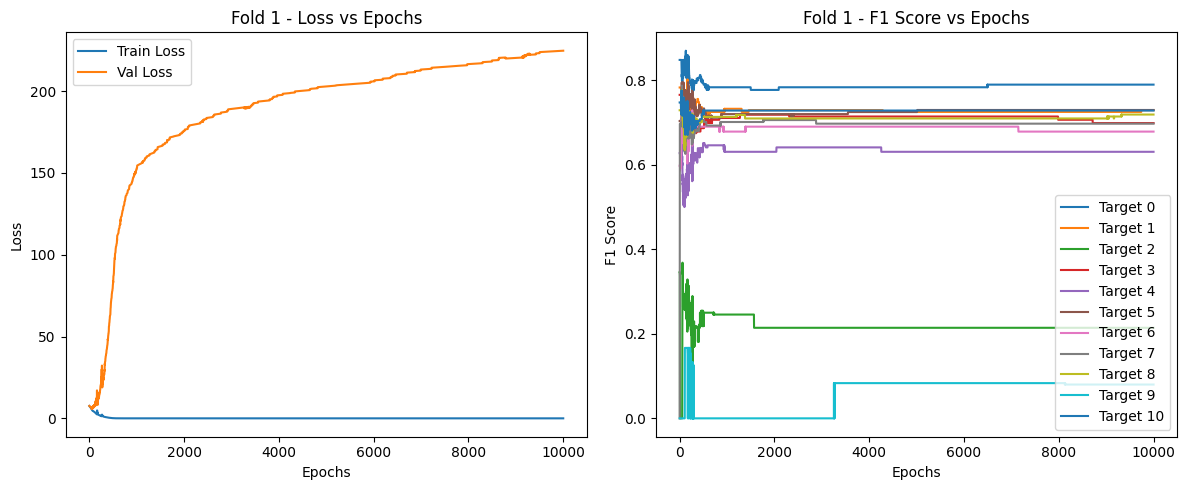

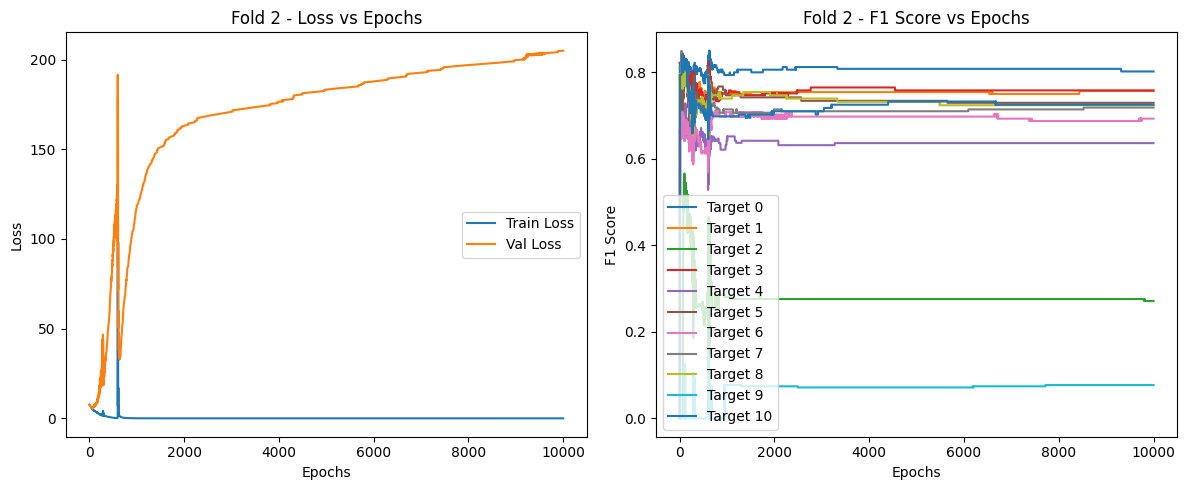

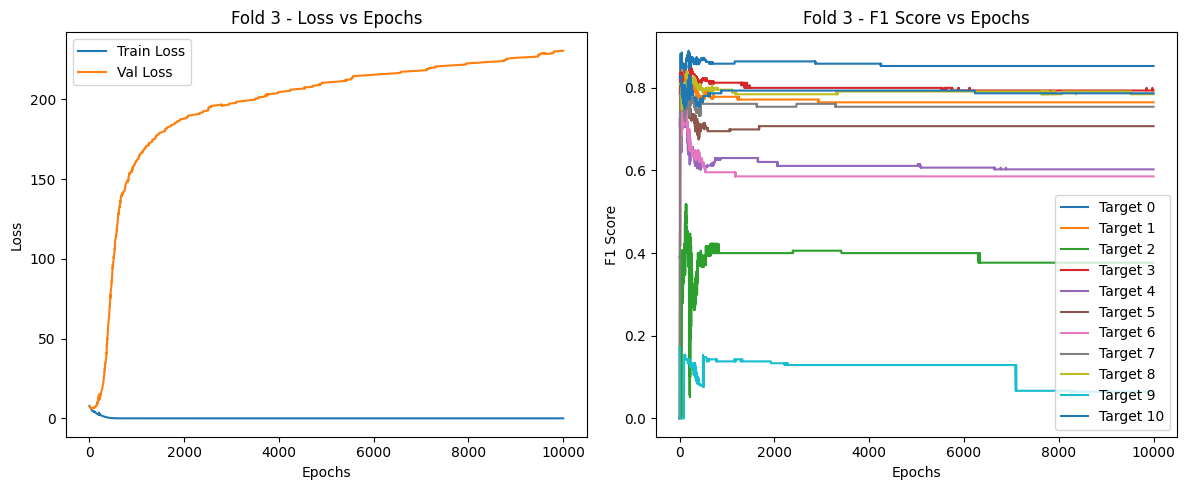

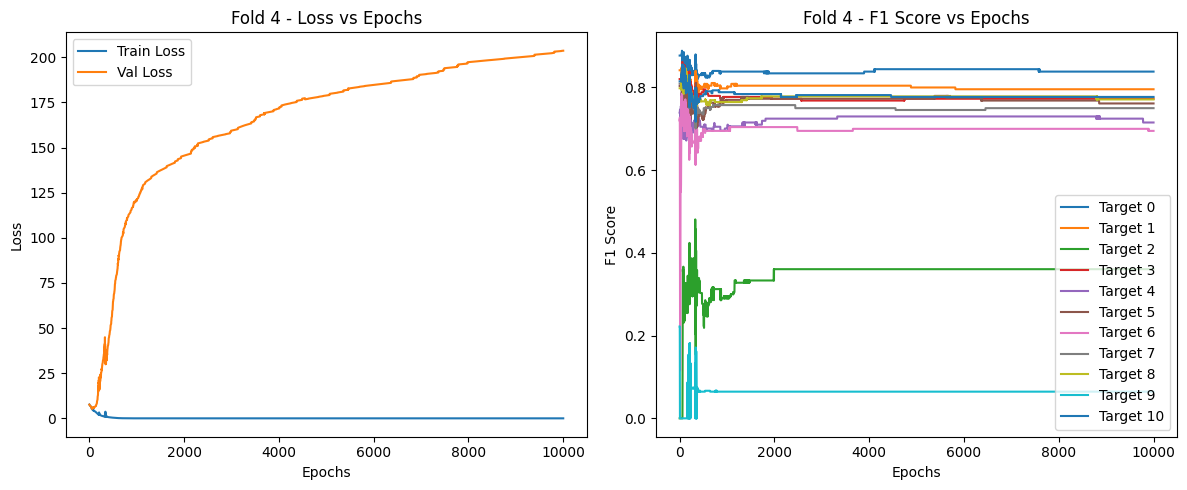

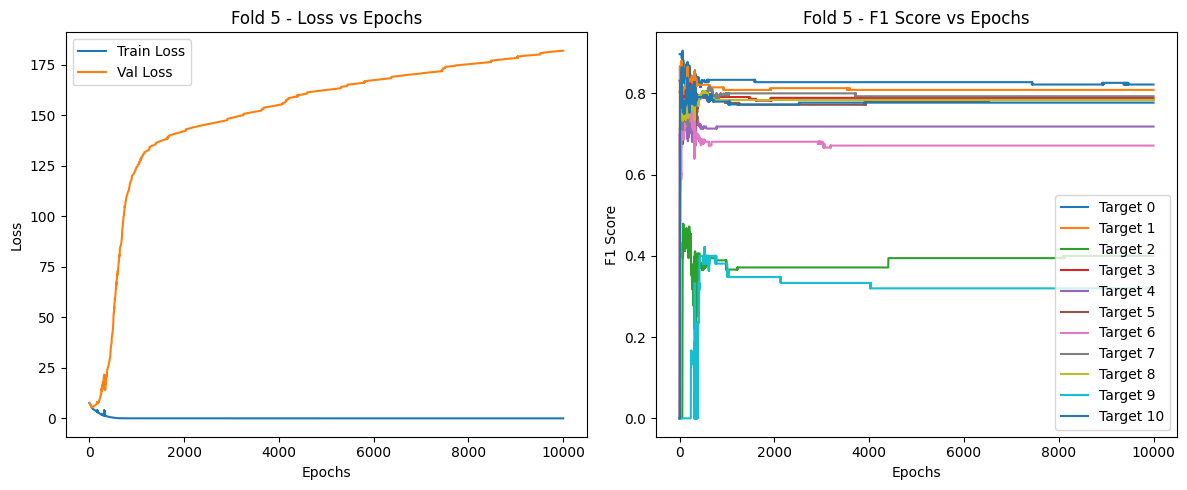

In [5]:
zipcode_predictions = {}  # Dictionary to store predictions for each zipcode

for zipcode, X in X_dict_imelda.items():
    fold_preds = []  # Store predictions from each model

    for model in saved_models:
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
            output_list = model(X_tensor)  # Output is a list of tensors (one per head)
            
            # Convert each tensor in the list to numpy format
            pred = [out.cpu().numpy().astype(float) for out in output_list]
            
            fold_preds.append(pred)

    # Convert fold_preds into a numpy array of shape (num_folds, num_heads)
    fold_preds = np.array(fold_preds)  # Shape: (num_folds, num_heads)
    
    # Averaging predictions across the 5 folds for each head
    final_pred = np.mean(fold_preds, axis=0).astype(float).squeeze()
    
    zipcode_predictions[zipcode] = final_pred  # Store final predictions

# Create DataFrame
result_df = pd.DataFrame.from_dict(zipcode_predictions, orient='index', columns=[
    'homeOwnersInsurance', 'floodInsurance', 'destroyed', 'floodDamage', 'roofDamage', 
    'tsaEligible', 'tsaCheckedIn', 'rentalAssistanceEligible', 'repairAssistanceEligible', 
    'replacementAssistanceEligible', 'personalPropertyEligible'
])

# Reset index to have zipcode as a column
result_df.reset_index(inplace=True)
result_df.rename(columns={'index': 'zipcode'}, inplace=True)

# Save to CSV
result_df.to_csv(os.path.join(save_path,'zipcode_predictions_imelda_complex_multihead.csv'), index=False)
print("Predictions saved to zipcode_predictions_imelda_complex_multihead.csv")

# Plotting the loss and F1 score curves
for fold_result in fold_results:
    history = fold_result['history']
    history_per_target = fold_result['history_per_target']
    
    # Plot training and validation loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train'], label='Train Loss')
    plt.plot(history['test'], label='Val Loss')
    plt.title(f'Fold {fold_result["fold"]} - Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot F1 score per target
    plt.subplot(1, 2, 2)
    for i in range(len(history_per_target)):
        plt.plot(history_per_target[i]['f1'], label=f'Target {i}')
    plt.title(f'Fold {fold_result["fold"]} - F1 Score vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.show()